In [1]:
import numpy as np
import random
from collections import defaultdict
import json

In [2]:
#Basic tic tac toe class
class ttt:
    def __init__(self):
        self.board = np.array([None] * 9)

    @staticmethod
    def check_for_win(board):
        WIN_STATES = [
            (0,1,2),
            (3,4,5),
            (6,7,8),
            (0,3,6),
            (1,4,7),
            (2,5,8),
            (0,4,8),
            (2,4,6)
        ]

        for a, b, c in WIN_STATES:
            if board[a] == board[b] == board[c] and board[a] == 1:
                return 100
            elif board[a] == board[b] == board[c] and board[a] == 2:
                return -100
        if len(ttt.legal_moves(board)) == 0:
            return 50
        else:
            return 0
    
    @staticmethod
    def legal_moves(board):
        return np.asarray(np.where(board == None)).flatten()

    def update_board(self, player, move):
        self.board[move] = player
        return self.check_for_win(self.board)      

    @staticmethod
    def display_board(board):
        def convert_board(board):
            readable_board = [' '] * 9
            for i in range(len(board)):
                if board[i] == 1:
                    readable_board[i] = 'X'
                elif board[i] == 2:
                    readable_board[i] = 'O'
            return readable_board
        board = convert_board(board)
        print(' {:1} | {:1} | {:1}'.format(board[0],board[1],board[2]))
        print('-----------')
        print(' {:1} | {:1} | {:1}'.format(board[3],board[4],board[5]))
        print('-----------')
        print(' {:1} | {:1} | {:1}'.format(board[6],board[7],board[8]))

In [22]:
#Random play
def random_play():
    q = defaultdict(lambda: [0,0,0,0,0,0,0,0,0])
    rewards = np.array([])
    games = [ttt() for i in range(5000)]
    
#     Hyperparameters
    epsilon = 1
    epsilon_min = 0.05
    epsilon_decay = 0.999997
    gamma = 0.9
    alpha = 0.1

    def p1_turn(game):
        def new_q(q, moves):
            new_q = [0] * 9
            for i in range(len(q)):
                if i not in moves:
                    new_q[i] = -200
                else:
                    new_q[i] = q[i]
            return new_q

        legal_moves = ttt.legal_moves(game.board)
        if (random.uniform(0, 1) > epsilon):
            move = np.argmax(new_q(q[str(game.board)], legal_moves))
        else:
            move = np.random.choice(legal_moves)
        old_board = game.board.copy()
        
#         generating new state after player 1 and 2 move
        game.update_board(1, move)
        p2_turn(game)

        if not(np.array_equal(old_board, game.board)):
            updateQ(old_board, move, game.board, ttt.check_for_win(game.board))
    
    def p2_turn(game):
        legal_moves = ttt.legal_moves(game.board)
        if (len(legal_moves) != 0):
            move = np.random.choice(legal_moves)
            game.update_board(2, move)

#     Q(s)[a] :=r+γ maxa′Q(s′)[a′]
#     r = reward of new state i.e. game.check_for_win(s')
#     maxa'Q(s')[a'] is just querying the table for s' and picking the largest value in the returned array
#     each update just changes one value out of [0,0,0,0,0,0,0,0,0] array
#     new state needs to be after opponent moves
    def updateQ(s, a, new_s, r):
#         [0,0,0,0,0,0,0,0,0]
        q_value = q[str(s)].copy()
        q_value[a] = ((1 - alpha) * q_value[a]) + (alpha * (r + (gamma * max(q[str(new_s)]))))
        q[str(s)] = q_value

    for game in games:
        first = random.randint(1,2)
#         Switch these out for AI first or random first
#         p_order = [1, 2]
        p_order = [first, 3-first]

        if (p_order[0] == 2):
            p2_turn(game)
        while (ttt.check_for_win(game.board) == 0):
            p1_turn(game)
    
        rewards = np.append(rewards, ttt.check_for_win(game.board))
        if (epsilon > epsilon_min):
            epsilon *= epsilon_decay

    fo = open("qtable.json", "w")
    json.dump(q, fo)
    fo.close()
#     len(q) AI first ~ 3217
#     len(q) random first ~ 6115, almost double as when always going first
    print("Player 1 Wins: ", np.asarray(np.where(rewards == 100)).flatten().size/len(rewards))
    print("Player 2 Wins: ", np.asarray(np.where(rewards == -100)).flatten().size/len(rewards))
    print("Ties: ", np.asarray(np.where(rewards == 50)).flatten().size/len(rewards))
    return q

In [6]:
def q_play(q):
    rewards = np.array([])
    games = [ttt() for i in range(10000)]

    def p_turn(player, game):
        def new_q(q, moves):
            new_q = [0] * 9
            for i in range(len(q)):
                if i not in moves:
                    new_q[i] = -200
                else:
                    new_q[i] = q[i]
            return new_q

        legal_moves = ttt.legal_moves(game.board)
        old_board = game.board.copy()        
        if (player == 1):
            move = np.argmax(new_q(q[str(game.board)], legal_moves))
        else:
            move = np.random.choice(legal_moves)
        game.update_board(player, move)

    for game in games:
        first = random.randint(1,2)
#         Switch these out for AI first or random first
#         p_order = [1, 2]
        p_order = [first, 3-first]

        while (ttt.check_for_win(game.board) == 0):
            p_turn(p_order[0], game)
            if (ttt.check_for_win(game.board) != 0 or len(ttt.legal_moves(game.board)) == 0):
                break
            p_turn(p_order[1], game)
    
        rewards = np.append(rewards, ttt.check_for_win(game.board))

    print()
    print("Player 1 Wins: ", np.asarray(np.where(rewards == 100)).flatten().size/len(rewards))
    print("Player 2 Wins: ", np.asarray(np.where(rewards == -100)).flatten().size/len(rewards))
    print("Ties: ", np.asarray(np.where(rewards == 50)).flatten().size/len(rewards))

In [34]:
def human_play():
#     or 'aifirst.json'
#     or 'qtables.json'
    with open('randomfirst.json') as f:
        q = json.load(f)
    game = ttt()

    def p_turn(game):
        def new_q(q, moves):
            new_q = [0] * 9
            for i in range(len(q)):
                if i not in moves:
                    new_q[i] = -200
                else:
                    new_q[i] = q[i]
            return new_q

        legal_moves = ttt.legal_moves(game.board)
        old_board = game.board.copy() 
        print(q[str(game.board)])       
        move = np.argmax(new_q(q[str(game.board)], legal_moves))
        game.update_board(1, move)

    def h_turn(game):
        ttt.display_board(game.board)
        move = input('Where would you like to play (0-8): ')
        game.update_board(2, int(move))

    first = random.randint(1,2)
#     Switch these out for AI first or random first
#     p_order = [1, 2]
    p_order = [first, 3-first]
    while (ttt.check_for_win(game.board) == 0):
        if (p_order[0] == 1):
            p_turn(game)
        else:
            h_turn(game)
        if (ttt.check_for_win(game.board) != 0):
            ttt.display_board(game.board)
            break
        if (p_order[0] == 1):
            h_turn(game)
        else:
            p_turn(game)
            
    print()
    if (ttt.check_for_win(game.board) == 100):
        print('AI wins')
    elif (ttt.check_for_win(game.board) == -100):
        print('You somehow beat the AI')
    else:
        print('You both played a perfect game. Tie')

Random opponent first performs pretty well after about only 50,000 training games. By 100,000 training games, loss percentage is down to only 0.0054%. To get rid of this tiny loss and make the AI play perfectly, I had to have it play 300,000 training games.

This was a lot more than when the AI went first every time. The number of states in the Q-table for AI first was ~3000, while the number of states in the Q-table for random first was ~6000. AI first was able to reach perfect play in around 150,000 training games.

The value for epsilon_decay needs to be tuned for each number of training games, since I use epsilon-greedy exploration. I found that the best results were when the random_play() function had a win percentage of ~65%. I had to adjust epsilon_decay so that the AI didn't get too good too quickly and do more exploitation than exploration. 

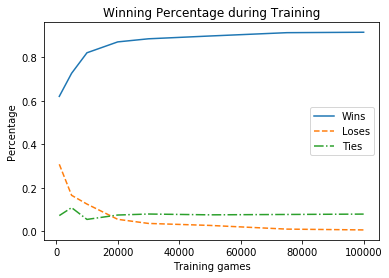

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

# training data
games = [1000, 5000, 10000, 20000, 30000, 50000, 75000, 100000]
wins = [0.6208, 0.7271, 0.8217, 0.8718, 0.8861, 0.899, 0.9143, 0.9163]
loses = [0.3078, 0.1649, 0.1245, 0.0542, 0.0353, 0.0261, 0.0091, 0.0054]
ties = [0.0714, 0.108, 0.0538, 0.074, 0.0786, 0.0749, 0.0766, 0.0783]

fig = plt.figure()
plt.plot(games, wins, linestyle='-', label='Wins')
plt.plot(games, loses, linestyle='--', label='Loses')
plt.plot(games, ties, linestyle='-.', label='Ties')
plt.xlabel('Training games')
plt.ylabel('Percentage')
plt.title('Winning Percentage during Training')
plt.legend()

In [27]:
q_play(random_play())

Player 1 Wins:  0.3806
Player 2 Wins:  0.4896
Ties:  0.1298

Player 1 Wins:  0.7653
Player 2 Wins:  0.1515
Ties:  0.0832


In [35]:
human_play()

[77.90445029770542, 78.10593492229714, 77.67634541325427, 76.22340389661238, 78.98153835071396, 74.65631098909273, 77.5337856601198, 73.33979034663115, 75.15761589918432]
   |   |  
-----------
   | X |  
-----------
   |   |  
Where would you like to play (0-8): 7
[88.24681106793906, 72.77844237026926, 86.90270077227109, 86.10467859597686, 0, 85.9724831131212, 87.27518690899038, 0, 85.1519276186582]
 X |   |  
-----------
   | X |  
-----------
   | O |  
Where would you like to play (0-8): 8
[0, -1.3904650997225279, 72.530772280586, 31.636274288687325, 0, 22.39536701060441, 89.99996000591942, 0, 0]
 X |   |  
-----------
   | X |  
-----------
 X | O | O
Where would you like to play (0-8): 2
[0, -42.05936354914919, 0, 99.99999998941072, 0, 62.09929903388406, 0, 0, 0]
 X |   | O
-----------
 X | X |  
-----------
 X | O | O

AI wins
